# GRU Neural Network for Insurance Claims Reserving

This notebook implements a Gated Recurrent Unit (GRU) neural network for predicting ultimate insurance claim amounts. The model processes sequential payment data to learn temporal patterns in claim development.

## Overview
- **Objective**: Predict ultimate claim amounts using payment history
- **Model**: GRU with log-link activation for positive predictions
- **Features**: Temporal claim development data (occurrence time, development period, payment amounts, etc.)
- **Evaluation**: Actual vs Expected plots, QQ plots, and model interpretability via SHAP

## Import Libraries

We import essential libraries for data processing, neural networks, and visualization.

In addition we import a number of custom functions from the `utils` folder, developed for this notebook but stored separately to simplify this flow and presentation.


In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import time
from datetime import datetime

# PyTorch imports

from torch.utils.tensorboard import SummaryWriter

# Scikit-learn imports
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline


# Local imports
from utils.config import ExperimentConfig, load_config_from_yaml
from utils.neural_networks import TabularNetRegressor, BasicLogGRU, ColumnKeeper, Make3D

#from data_engineering import load_data, process_data_davide, create_train_test_datasets_davide
from utils.data_engineering import load_data, process_data, create_train_test_datasets
from utils.tensorboard import generate_enhanced_tensorboard_outputs, create_actual_vs_expected_plot

from utils.excel import save_df_to_excel

/Users/jacky/GitRepos/MLR_working_party/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configuration Setup

We configure the experiment settings, including model parameters, training settings, and output options.

Our configuration is read a config file in the utils folder.

In [2]:

# Load from YAML file
config = load_config_from_yaml('configs/GRU_NJC_config.yaml')

# Set pandas display options
pd.options.display.float_format = '{:,.2f}'.format

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

SEED =  config['training'].seed # 42 
rng = np.random.default_rng(SEED) 

# Create timestamp for logging
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_name = f"GRU_experiment_NJC_{timestamp}"  # Customize as needed

# Initialize TensorBoard writer
writer = SummaryWriter(log_dir=f"runs/{run_name}")
log_filename = f"logs/{run_name}.xlsx"

print(f"Experiment timestamp: {timestamp}")
print(f"Output file: {log_filename}")

Experiment timestamp: 20260225_214853
Output file: logs/GRU_experiment_NJC_20260225_214853.xlsx


## Data Loading and Processing

We load the raw insurance claims data and process it for neural network training. This includes:
- Loading raw data from CSV
- Feature engineering (development periods, payment indicators, etc.)
- Creating train/test splits based on claim settlement status

In [3]:
# Load original data
dat_orig = load_data(config)
print(f"Original data shape: {dat_orig.shape}")
print(f"Original data columns: {list(dat_orig.columns)}")

# Save original data to Excel
save_df_to_excel(dat_orig, df_name="Original Data", filename=log_filename, mode='w')

Original data shape: (19322, 13)
Original data columns: ['Unnamed: 0', 'claim_no', 'pmt_no', 'occurrence_period', 'occurrence_time', 'claim_size', 'notidel', 'setldel', 'payment_time', 'payment_period', 'payment_size', 'payment_inflated', 'payment_delay']
Saved DataFrame to 'logs/GRU_experiment_NJC_20260225_214853.xlsx' as sheet 'Original Data'


In [4]:
# Process data (feature engineering, filtering, etc.)
dat = process_data(config, dat_orig)
print(f"Processed data shape: {dat.shape}")
print(f"New columns added: {set(dat.columns) - set(dat_orig.columns)}")

# Save processed data to Excel
save_df_to_excel(dat, df_name="Processed Data", filename=log_filename, mode='a')

Processed data shape: (15262, 35)
New columns added: {'is_settled_future', 'payment_size_cumulative', 'L250k', 'settled_flag', 'train_ind', 'log1_paid_cumulative', 'curr_paid', 'future_paid_cum', 'curr_dev', 'train_settled', 'train_ind_time', 'curr_pmtno', 'test_ind_time', 'future_flag'}
Saved DataFrame to 'logs/GRU_experiment_NJC_20260225_214853.xlsx' as sheet 'Processed Data'


## Train/Test Split Creation

We create training and test datasets:
- **Training**: Settled claims with complete payment history
- **Testing**: Unsettled claims for out-of-sample prediction

In [5]:
# Create train/test datasets
trainx, y_train, testx, y_test = create_train_test_datasets(dat, config)

print(f"Training features shape: {trainx.shape}")
print(f"Training targets shape: {y_train.shape}")
print(f"Test features shape: {testx.shape}")
print(f"Test targets shape: {y_test.shape}")

# Save datasets to Excel
save_df_to_excel(trainx, df_name="x_train", filename=log_filename, mode='a')
save_df_to_excel(y_train, df_name="y_train", filename=log_filename, mode='a')
save_df_to_excel(testx, df_name="x_test", filename=log_filename, mode='a')
save_df_to_excel(y_test, df_name="y_test", filename=log_filename, mode='a')

Training features shape: (5077, 6)
Training targets shape: (1298,)
Test features shape: (909, 6)
Test targets shape: (102,)
Saved DataFrame to 'logs/GRU_experiment_NJC_20260225_214853.xlsx' as sheet 'x_train'
Saved DataFrame to 'logs/GRU_experiment_NJC_20260225_214853.xlsx' as sheet 'y_train'
Saved DataFrame to 'logs/GRU_experiment_NJC_20260225_214853.xlsx' as sheet 'x_test'
Saved DataFrame to 'logs/GRU_experiment_NJC_20260225_214853.xlsx' as sheet 'y_test'


In [6]:
# Extract configuration values for model setup
features = config['data'].features
data_cols = config['data'].data_cols
youtput = config['data'].output_field

# Print dataset info
nclms = trainx['claim_no'].nunique()
nfeatures = len(features)

print(f"Number of unique claims in training: {nclms}")
print(f"Number of features: {nfeatures}")
print(f"Features: {features}")
print(f"Target variable: {youtput}")

Number of unique claims in training: 1298
Number of features: 5
Features: ['occurrence_time', 'notidel', 'development_period', 'pmt_no', 'log1_paid_cumulative']
Target variable: claim_size


## Model Pipeline Setup

We create a scikit-learn pipeline that:
1. **ColumnKeeper**: Selects relevant columns
2. **MinMaxScaler**: Normalizes features to [0,1] range (critical for neural networks)
3. **Make3D**: Converts tabular data to 3D tensors for GRU processing
4. **TabularNetRegressor**: Wraps the GRU model with training logic

In [7]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[('scale', MinMaxScaler(), features)],
    remainder='passthrough',
    verbose_feature_names_out=False
)

preprocessor.set_output(transform="pandas")

model_NN = Pipeline(
    steps=[
        ("keep", ColumnKeeper(data_cols)),   
        ('zero_to_one', preprocessor),       # Important! Standardize deep learning inputs.
        ('3Dtensor', Make3D(features)),
        ("model", TabularNetRegressor(
            BasicLogGRU, 
            #n_input=nfeatures, 
            n_hidden=config['model'].n_hidden, 
            #n_output=config['model'].n_output, 
            max_iter=config['training'].nn_iter,
            enable_shap=config['training'].enable_shap,
            shap_log_frequency=config['tensorboard'].shap_log_frequency,
            seed=SEED,
            config = config
        ))
    ]
)


print("Model pipeline created successfully")
print(f"Hidden units: {config['model'].n_hidden}")
print(f"Training iterations: {config['training'].nn_iter}")

Model pipeline created successfully
Hidden units: 32
Training iterations: 2001


## Model Training

We train the GRU model on the sequential payment data. The model learns to predict ultimate claim amounts from partial payment histories.



In [8]:
def train_model(model, trainx, y_train, config: ExperimentConfig):
    """
    Train the neural network model with timing.
    
    Args:
        model: The model pipeline to train
        trainx: Training features
        y_train: Training targets
        config: Experiment configuration
        
    Returns:
        Trained model and elapsed time
    """
    print("Starting model training...")
    start_time = time.time()
    
    model.fit(trainx, y_train)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training completed. Execution time: {elapsed_time:.2f} seconds")
    
    return model, elapsed_time

# Train the model
trained_model, training_time = train_model(model_NN, trainx, y_train, config)

Starting model training...
SHAP explainer initialized successfully
Epoch: 0 Train RMSE: 213239.34375 Train Loss: -1588487.25
Epoch: 200 Train RMSE: 131161.65625 Train Loss: -1656133.875
Epoch: 400 Train RMSE: 91562.8203125 Train Loss: -1674031.125
Epoch: 600 Train RMSE: 113053.546875 Train Loss: -1667083.25
Epoch: 800 Train RMSE: 86340.28125 Train Loss: -1675344.5
Epoch: 1000 Train RMSE: 85212.3046875 Train Loss: -1675559.0
Epoch: 1200 Train RMSE: 84019.34375 Train Loss: -1675762.625
Epoch: 1400 Train RMSE: 82815.3828125 Train Loss: -1675940.125
Epoch: 1600 Train RMSE: 81930.3203125 Train Loss: -1676058.25
Epoch: 1800 Train RMSE: 81529.734375 Train Loss: -1676109.75
Epoch: 2000 Train RMSE: 81464.953125 Train Loss: -1676118.0
Training completed. Execution time: 87.30 seconds


## Training Results and SHAP Analysis

After training, we generate predictions and SHAP explanations to understand feature importance. SHAP values show how each feature contributes to individual predictions.

To observe the tensorboard logs, run the following command in your terminal:

`tensorboard --logdir=./02_code/runs/`

In [9]:
train = (dat.loc[(dat.train_ind_time == 1) & (dat.train_ind == 1) & (dat.train_settled == 1)])

# Generate enhanced outputs including SHAP analysis
train_pred = generate_enhanced_tensorboard_outputs(trained_model, train, config, writer)
save_df_to_excel(train_pred, df_name="pred_train", filename=log_filename, mode='a')


# Generate basic predictions
y_pred = trained_model.predict(trainx)
save_df_to_excel(pd.DataFrame(y_pred, columns=['prediction']), df_name="y_pred_train", filename=log_filename, mode='a')

print(f"Training predictions generated for {len(train_pred)} records")
print(f"Mean predicted claim amount: ${train_pred['pred_claims'].mean():,.2f}")
print(f"Mean actual claim amount: ${train_pred[youtput].mean():,.2f}")

Generating enhanced tensorboard outputs...
(1298, 2)
Generating SHAP explanations for trained model...


/Users/jacky/GitRepos/MLR_working_party/.venv/lib/python3.13/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/jacky/GitRepos/MLR_working_party/02_code/utils/tensorboard.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_transformed, dtype=torch.float32)


get_shap_values: shap_values.shape: (200, 20, 5, 1)
DEBUG: log_shap_explanations/X shape: torch.Size([200, 20, 5])
DEBUG: log_shap_explanations/max_samples: 200
DEBUG: shap_values.shape: (200, 20, 5)
DEBUG: shap_values[0] shape: (20, 5)
DEBUG: len(shap_values.shape): 3
DEBUG: shap_values_2d = shap_values.reshape(-1, shap_values.shape[-1])
Final_Model_SHAP/mean_abs_shap: [0.01615059 0.00408142 0.01298053 0.00353053 0.06375743]
Final_Model_SHAP/Summary_Bar
Final_Model_SHAP/Summary_Beeswarm
Final_Model_SHAP/descending_feature_indices: [4 0 2 1 3]
Feature Name: log1_paid_cumulative (Importance: 0.0638)
Final_Model_SHAP/Dependence_Plot/log1_paid_cumulative
Feature Name: occurrence_time (Importance: 0.0162)
Final_Model_SHAP/Dependence_Plot/occurrence_time
Feature Name: development_period (Importance: 0.0130)
Final_Model_SHAP/Dependence_Plot/development_period
Feature Name: notidel (Importance: 0.0041)
Final_Model_SHAP/Dependence_Plot/notidel
Feature Name: pmt_no (Importance: 0.0035)
Final_Mo

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

## Training Set Evaluation Plots

We create several diagnostic plots to evaluate model performance on training data:
- **Actual vs Expected**: Scatter plots comparing predictions to actual values
- **Logged Plots**: Log-transformed versions for better visualization of large values
- **Ultimate Claims**: Predictions for final claim amounts only

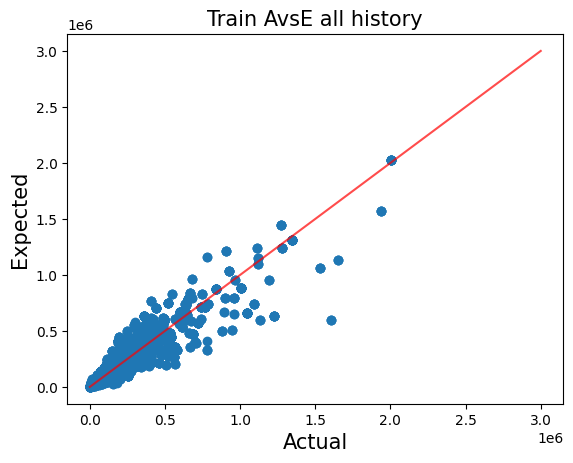

In [10]:

# Actual vs Expected - All Training History
fig, ax = create_actual_vs_expected_plot(
    train_pred, youtput, "pred_claims", 
    'Train AvsE all history', 
    writer, 'AvsE all Train'
)
fig

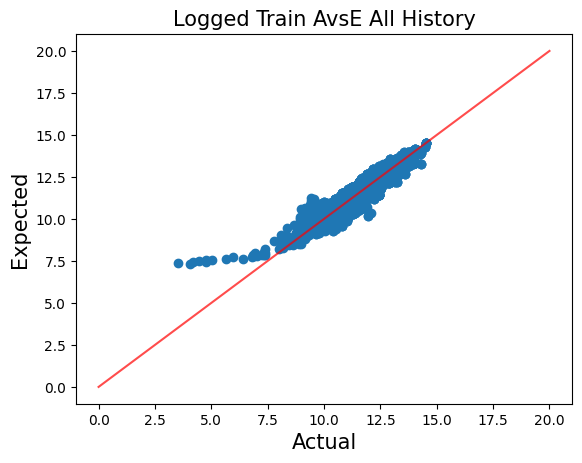

In [11]:
# Logged Actual vs Expected - Training
fig, ax = create_actual_vs_expected_plot(
    train_pred, "log_actual", "log_pred_claims", 
    'Logged Train AvsE All History', 
    writer, 'AvsE Logged All Train',
    max_val=20
)

fig

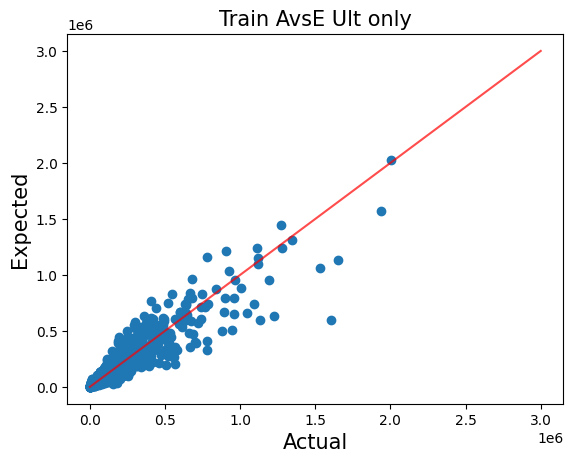

In [12]:
# AvsE Ult - Train
dat_byclaim = train_pred.groupby("claim_no").last()
fig, ax = create_actual_vs_expected_plot(
    dat_byclaim, "claim_size", "pred_claims", 
    'Train AvsE Ult only', 
    writer, 'AvsE Ult only Train'
)

fig

We create several QQ diagnostic plots to evaluate model performance on training data:
- **Actual vs Expected**: Scatter plots comparing predictions to actual values
- **Logged Plots**: Log-transformed versions for better visualization of large values

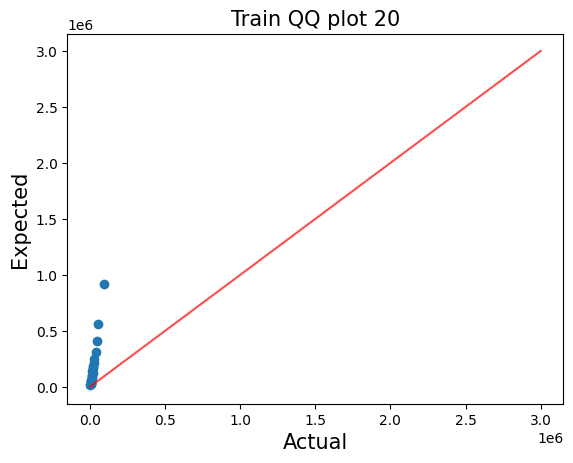

In [13]:
train_pred["pred_claims_20cile"] = pd.qcut(train_pred["pred_claims"], 20, labels=False, duplicates='drop')
#X_sum = train_pred.groupby("pred_claims_20cile").agg("mean").reset_index()
#X_sum = train_pred.groupby("pred_claims_20cile")[["payment_size", "pred_claims", "log_actual", "log_pred_claims"]].mean().reset_index()
X_sum = train_pred.groupby("pred_claims_20cile").mean(numeric_only=True).reset_index()

#X_sum = train_pred.groupby("pred_claims_20cile").agg(
#    payment_size_mean=("payment_size","mean"),
#    pred_claims_mean=("pred_claims","mean")
#).reset_index()

# QQ - Train
fig, ax  = create_actual_vs_expected_plot(
    X_sum, "payment_size", "pred_claims", 
    'Train QQ plot 20', 
    writer, 'QQ plot Train'
)
fig


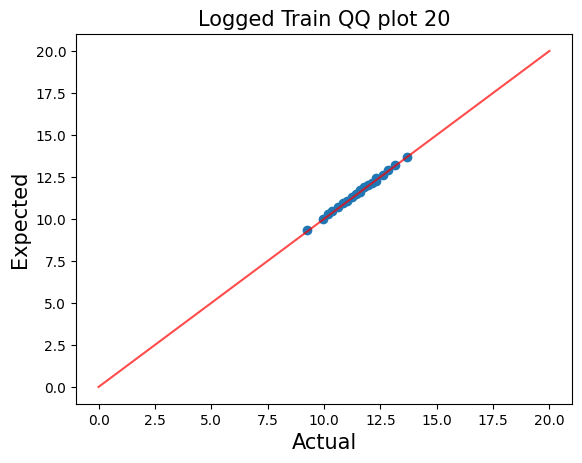

In [14]:

# Logged QQ - Train
fig, ax  = create_actual_vs_expected_plot(
    X_sum, "log_actual", "log_pred_claims", 
    'Logged Train QQ plot 20', 
    writer, 'QQ plot Logged Train',
    max_val = 20,
)

fig

## Test Set Evaluation Plots

We then repeat the process to create several diagnostic plots to evaluate model performance on test data:
- **Actual vs Expected**: Scatter plots comparing predictions to actual values
- **Logged Plots**: Log-transformed versions for better visualization of large values
- **Ultimate Claims**: Predictions for final claim amounts only

In [15]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Create plots TEST
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

test = (dat.loc[(dat.test_ind_time == 1) & (dat.train_ind == 0) & (dat.train_settled == 0)])

youtput="claim_size"
y_pred=model_NN.predict(test)

y_predx=model_NN.predict(testx)

#merge y_pred back into dat for each claim
claim_nos = test["claim_no"].drop_duplicates()
pred_df = pd.DataFrame({
    "claim_no": claim_nos.values,
    "pred_claims": y_pred
})

if "pred_claims" in test.columns:
    dat = dat.drop(columns=["pred_claims"])

test_pred = test.merge(pred_df, on="claim_no", how="left")

test_pred["log_pred_claims"]=test_pred["pred_claims"].apply(lambda x: np.log(x+1))
test_pred["log_actual"]=test_pred[youtput].apply(lambda x: np.log(x+1))

test_pred["rpt_delay"]=np.ceil(train_pred.notidel).astype(int)

test_pred["diff"]=test_pred[youtput]-train_pred["pred_claims"]
test_pred["diffp"]=(test_pred[youtput]-test_pred["pred_claims"])/test_pred[youtput]

save_df_to_excel(test_pred, df_name="pred_test", filename=log_filename, mode='a')


Saved DataFrame to 'logs/GRU_experiment_NJC_20260225_214853.xlsx' as sheet 'pred_test'


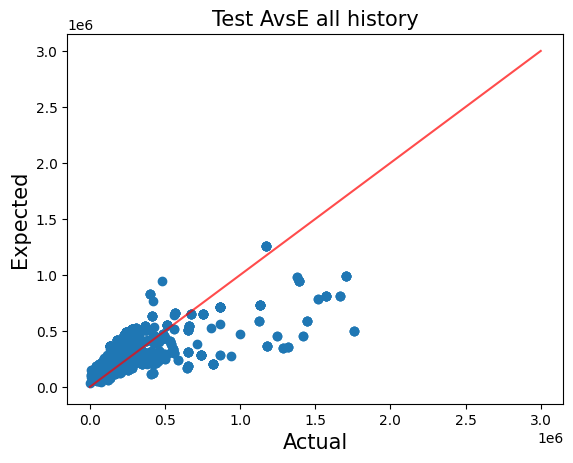

In [16]:
# AvsE all - Test
fig, ax = create_actual_vs_expected_plot(
    test_pred, youtput, "pred_claims", 
    'Test AvsE all history', 
    writer, 'AvsE all Test'
)

fig

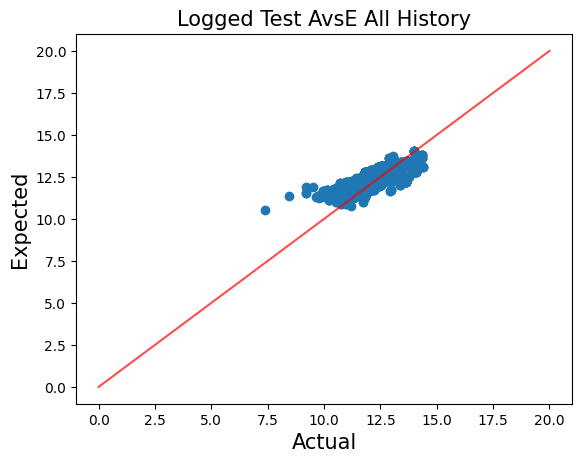

In [17]:
# Logged AvsE all - Test
fig, ax = create_actual_vs_expected_plot(
    test_pred, "log_actual", "log_pred_claims", 
    'Logged Test AvsE All History', 
    writer, 'AvsE Logged All Test',
    max_val=20
)

fig

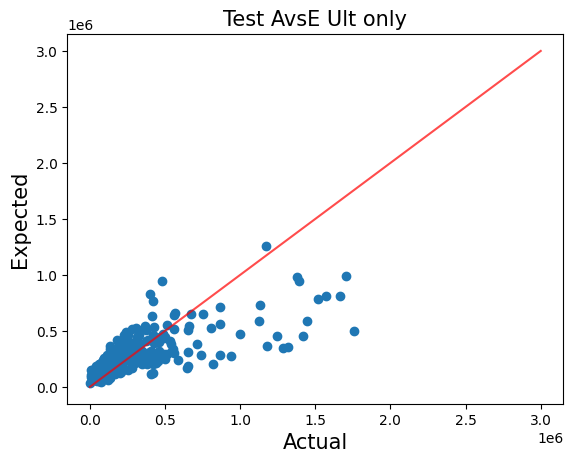

In [18]:
# AvsE Ult - Test
dat_byclaim = test_pred.groupby("claim_no").last()
fig, ax = create_actual_vs_expected_plot(
    dat_byclaim, "claim_size", "pred_claims", 
    'Test AvsE Ult only', 
    writer, 'AvsE Ult only Test'
)

fig

We create several QQ diagnostic plots to evaluate model performance on test data:
- **Actual vs Expected**: Scatter plots comparing predictions to actual values
- **Logged Plots**: Log-transformed versions for better visualization of large values

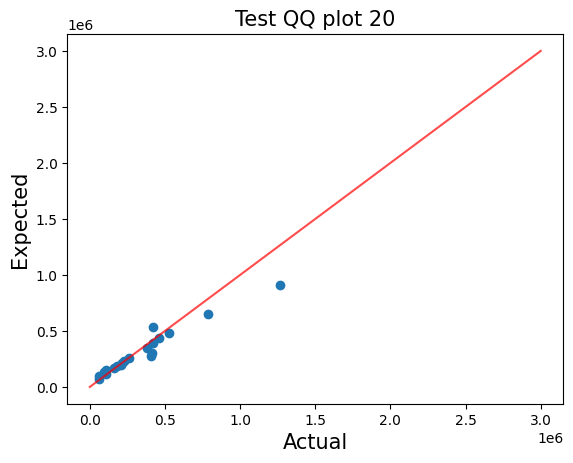

In [19]:
test_pred["pred_claims_20cile"] = pd.qcut(test_pred["pred_claims"], 20, labels=False, duplicates='drop')
#X_sum = test_pred.groupby("pred_claims_20cile").agg("mean").reset_index()
X_sum = test_pred.groupby("pred_claims_20cile").mean(numeric_only=True).reset_index()

# QQ - Test
fig, ax  = create_actual_vs_expected_plot(
    X_sum, "claim_size", "pred_claims", 
    'Test QQ plot 20', 
    writer, 'QQ plot Test'
)

fig


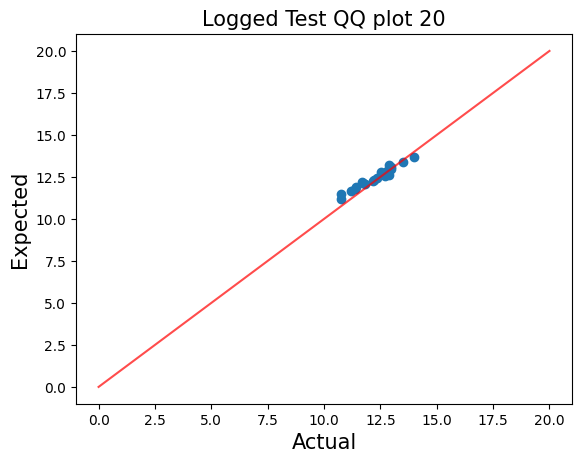

In [20]:

# Logged QQ - Test
fig, ax  = create_actual_vs_expected_plot(
    X_sum, "log_actual", "log_pred_claims", 
    'Logged Test QQ plot 20', 
    writer, 'QQ plot Logged Test', 
    max_val = 20,
)

fig

## Occurrence Period Plot

We can review the accuracy of the trained model by looking at Actuals and Expected values by Occrrence Period. 

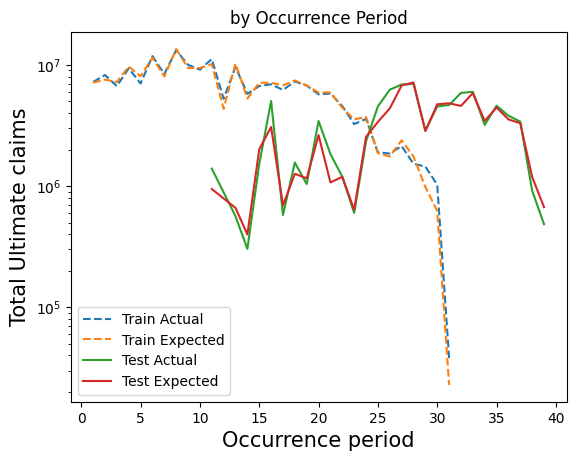

In [21]:

datTrainUlt=train_pred.groupby("claim_no").last()
datTestUlt=test_pred.groupby("claim_no").last()

datTrain_occ = datTrainUlt.groupby("occurrence_period").agg({youtput: "sum", "pred_claims": "sum"})
datTest_occ = datTestUlt.groupby("occurrence_period").agg({youtput: "sum", "pred_claims": "sum"})

plt.figure()

plt.plot(datTrain_occ.index, datTrain_occ[youtput])
plt.plot(datTrain_occ.index, datTrain_occ.pred_claims)

plt.plot(datTest_occ.index, datTest_occ[youtput])
plt.plot(datTest_occ.index, datTest_occ.pred_claims)

fig, ax = plt.subplots()
ax.plot(datTrain_occ.index, datTrain_occ[youtput], linestyle='--', label='Train Actual')
ax.plot(datTrain_occ.index, datTrain_occ.pred_claims, linestyle='--', label='Train Expected')
ax.plot(datTest_occ.index, datTest_occ[youtput], label='Test Actual')
ax.plot(datTest_occ.index, datTest_occ.pred_claims, label='Test Expected')
ax.set_yscale("log") 
ax.set_xlabel('Occurrence period', fontsize=15)
ax.set_ylabel('Total Ultimate claims', fontsize=15)
ax.set_title('by Occurrence Period')     
ax.legend()
writer.add_figure('by Occur Period', fig)


fig


# Development date plots


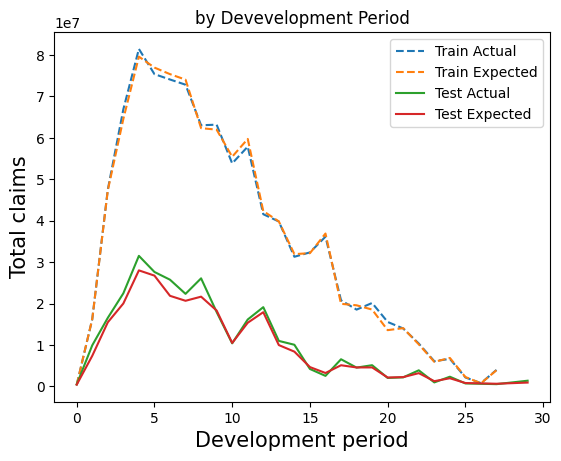

In [22]:
datTrain_dev = train_pred.groupby("development_period").agg({youtput: "sum", "pred_claims": "sum"})
datTest_dev = test_pred.groupby("development_period").agg({youtput: "sum", "pred_claims": "sum"})

plt.figure()

plt.plot(datTrain_dev.index, datTrain_dev[youtput])
plt.plot(datTrain_dev.index, datTrain_dev.pred_claims)

plt.plot(datTest_dev.index, datTest_dev[youtput])
plt.plot(datTest_dev.index, datTest_dev.pred_claims)


fig, ax = plt.subplots()
ax.plot(datTrain_dev.index, datTrain_dev[youtput], linestyle='--', label='Train Actual')
ax.plot(datTrain_dev.index, datTrain_dev.pred_claims, linestyle='--', label='Train Expected')
ax.plot(datTest_dev.index, datTest_dev[youtput], label='Test Actual')
ax.plot(datTest_dev.index, datTest_dev.pred_claims, label='Test Expected')
ax.set_xlabel('Development period', fontsize=15)
ax.set_ylabel('Total claims', fontsize=15)
ax.set_title('by Devevelopment Period')     
ax.legend()
writer.add_figure('by Dev Period', fig)

fig

## Development Period Plot

We can review the accuracy of the trained model by looking at Actuals and Expected values by Development Period. 

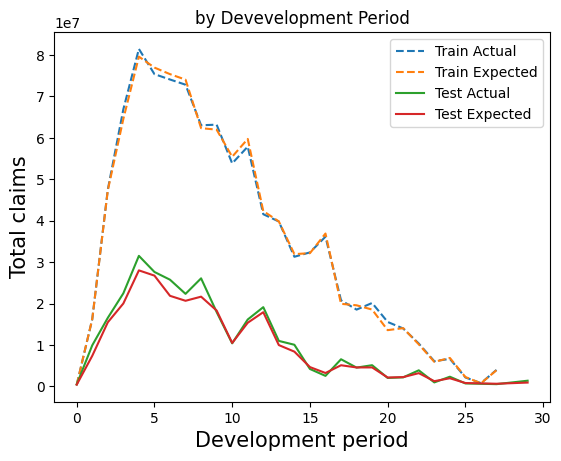

In [23]:
datTrain_dev = train_pred.groupby("development_period").agg({youtput: "sum", "pred_claims": "sum"})
datTest_dev = test_pred.groupby("development_period").agg({youtput: "sum", "pred_claims": "sum"})

plt.figure()

plt.plot(datTrain_dev.index, datTrain_dev[youtput])
plt.plot(datTrain_dev.index, datTrain_dev.pred_claims)

plt.plot(datTest_dev.index, datTest_dev[youtput])
plt.plot(datTest_dev.index, datTest_dev.pred_claims)


fig, ax = plt.subplots()
ax.plot(datTrain_dev.index, datTrain_dev[youtput], linestyle='--', label='Train Actual')
ax.plot(datTrain_dev.index, datTrain_dev.pred_claims, linestyle='--', label='Train Expected')
ax.plot(datTest_dev.index, datTest_dev[youtput], label='Test Actual')
ax.plot(datTest_dev.index, datTest_dev.pred_claims, label='Test Expected')
ax.set_xlabel('Development period', fontsize=15)
ax.set_ylabel('Total claims', fontsize=15)
ax.set_title('by Devevelopment Period')     
ax.legend()
writer.add_figure('by Dev Period', fig)

fig